In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import textstat
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy 

In [12]:
news = pd.read_excel("Dataset/news_excerpts_parsed.xlsx")
news.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


Text(0.5, 1.0, 'Number of characters')

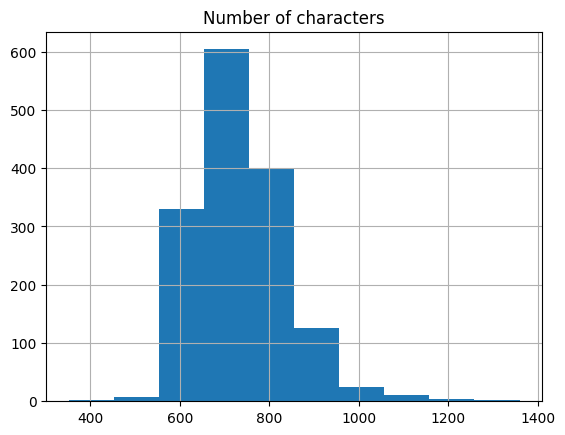

In [13]:
#Histogram of Characters 
news['Text'].str.len().hist()
plt.title("Number of characters")

In [14]:
def plot_word_nums_hist(text):
    text.str.split().map(lambda x: len(x)).hist()

Text(0.5, 1.0, 'Number of words')

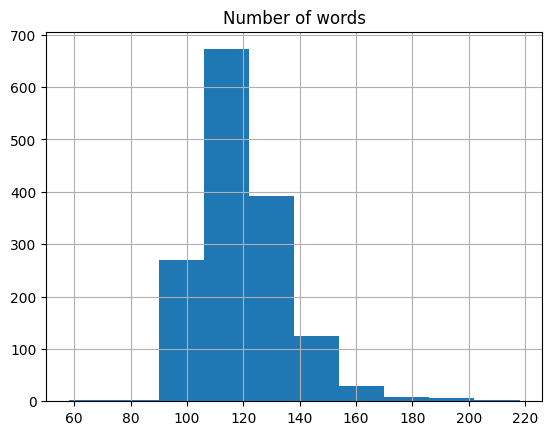

In [15]:
plot_word_nums_hist(news['Text'])
plt.title("Number of words")

In [16]:
# Load English stopwords
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

Text(0.5, 1.0, 'Top Stopword Count')

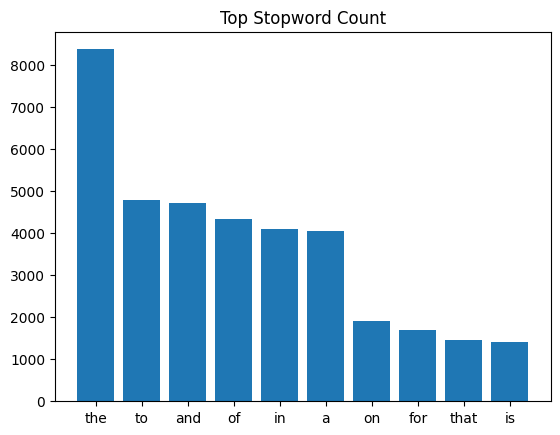

In [18]:
plot_top_stopwords_barchart(news['Text'])
plt.title('Top Stopword Count')

In [19]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter([word.strip('.,!?;"\'').lower() for word in corpus])
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:60]:
        if word not in stop and word != '–':
            x.append(word)
            y.append(count)
    
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top non-stopwords Count')

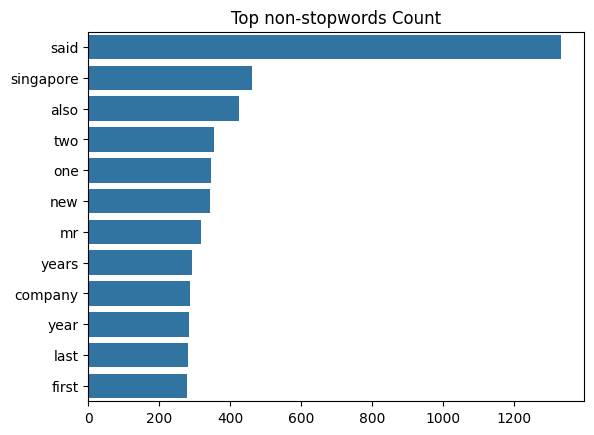

In [20]:
plot_top_non_stopwords_barchart(news['Text'])
plt.title("Top non-stopwords Count")

In [21]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(corpus, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top Bigram Count')

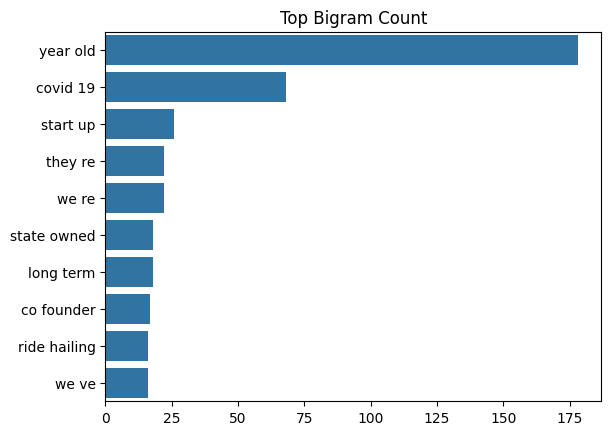

In [22]:
plot_top_ngrams_barchart(news['Text'],2)
plt.title("Top Bigram Count")

Text(0.5, 1.0, 'Top Trigram Count')

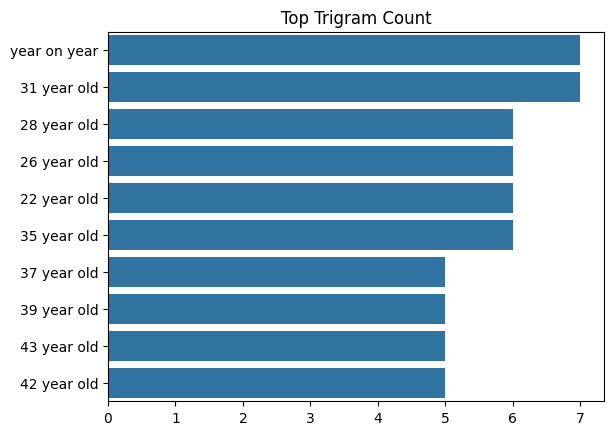

In [24]:
plot_top_ngrams_barchart(news['Text'],3)
plt.title("Top Trigram Count")

In [57]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in text:
        words=news.split()
        words = [w.strip('.,!?;"\'') for w in words]

        words=[lem.lemmatize(w) for w in words if len(w)>2 and (w.lower() not in stop)]

        corpus.append(words)
    return corpus

corpus=preprocess_news(news)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [59]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 10,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.010*"said" + 0.006*"Singapore" + 0.005*"year" + 0.004*"company" + 0.004*"first" + 0.003*"also" + 0.003*"two" + 0.003*"new" + 0.002*"time" + 0.002*"including"'),
 (1,
  '0.011*"said" + 0.005*"people" + 0.005*"year" + 0.004*"also" + 0.003*"one" + 0.003*"Singapore" + 0.003*"first" + 0.002*"time" + 0.002*"say" + 0.002*"China"'),
 (2,
  '0.009*"said" + 0.006*"trade" + 0.005*"year" + 0.005*"billion" + 0.004*"two" + 0.004*"per" + 0.004*"cent" + 0.004*"also" + 0.004*"China" + 0.003*"family"'),
 (3,
  '0.009*"said" + 0.005*"Singapore" + 0.005*"year" + 0.003*"Russian" + 0.003*"company" + 0.003*"first" + 0.003*"Ukraine" + 0.002*"two" + 0.002*"new" + 0.002*"also"'),
 (4,
  '0.008*"said" + 0.003*"year" + 0.003*"per" + 0.003*"one" + 0.002*"cent" + 0.002*"Singapore" + 0.002*"company" + 0.002*"two" + 0.002*"also" + 0.002*"would"'),
 (5,
  '0.012*"said" + 0.005*"Singapore" + 0.004*"country" + 0.004*"year" + 0.004*"company" + 0.003*"China" + 0.003*"would" + 0.002*"one" + 0.002*"two" + 0.002*"a

In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.064903  0.033831       1        1  15.977424
2     -0.066282  0.005473       2        1  14.055166
0     -0.022853  0.035020       3        1  10.940432
7     -0.003388  0.069889       4        1   9.790498
1      0.035255 -0.014609       5        1   9.240337
9      0.011580 -0.131818       6        1   8.791961
3     -0.004670  0.007444       7        1   8.660948
5     -0.065869 -0.038667       8        1   8.604289
4      0.072666  0.014018       9        1   7.196290
8      0.108462  0.019419      10        1   6.742656, topic_info=          Term        Freq       Total Category  logprob  loglift
810      trade  150.000000  150.000000  Default  30.0000  30.0000
2688    Israel   43.000000   43.000000  Default  29.0000  29.0000
511    Russian   72.000000   72.000000  Default  28.0000  28.0000
1026    attack   64.000000   64.000000  Default  27.0000  27.0000
148    country  182.000000  182.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
289        day   10.232480  130.195633  Topic10  -6.5576   0.1532
4083       way    8.522815   69.607691  Topic10  -6.7405   0.5966
144   business    9.362034  130.798526  Topic10  -6.6465   0.0597
695       home    8.769525  102.712510  Topic10  -6.7119   0.2361
213        per    9.114253  178.612775  Topic10  -6.6734  -0.2787

[824 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
4976       7  0.624141   (MHA)
15434     10  0.648865  19-NS2
223        1  0.179832    2021
223        2  0.245226    2021
223        3  0.049045    2021
...      ...       ...     ...
272        6  0.037940    year
272        7  0.090634    year
272        8  0.080096    year
272        9  0.046371    year
272       10  0.059018    year

[2411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 1, 8, 2, 10, 4, 6, 5, 9])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


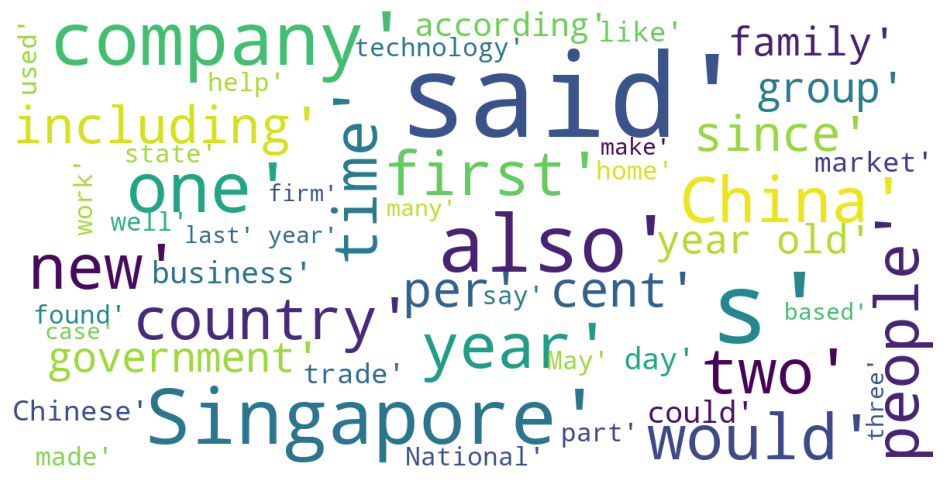

In [68]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    corpus = preprocess_news(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(news)

<Axes: >

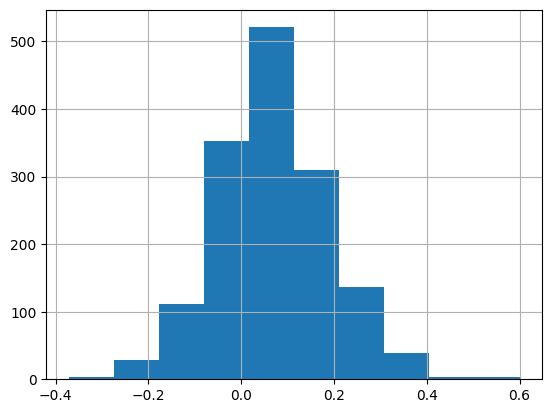

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['Text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

<BarContainer object of 3 artists>

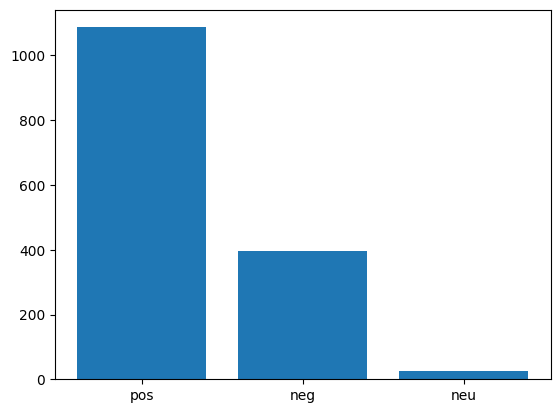

In [76]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [78]:
news[news['polarity']=='neg']['Text'].head()

3    SINGAPORE: A 45-year-old man linked to Singapo...
5    After twelve days of deliberation, a Vienna co...
6    China’s cyberspace regulator fined Didi Global...
7    On Thursday, the Brussels Criminal Court’s pro...
8    The Prague 3 District Court this morning sente...
Name: Text, dtype: object

In [79]:
news[news['polarity']=='pos']['Text'].head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
4    The Department of Education imposed a record $...
9    Sanjay Shah, who was arrested in June 2022 in ...
Name: Text, dtype: object

In [81]:
nlp = spacy.load('en_core_web_sm')

In [83]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['Text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

<Axes: >

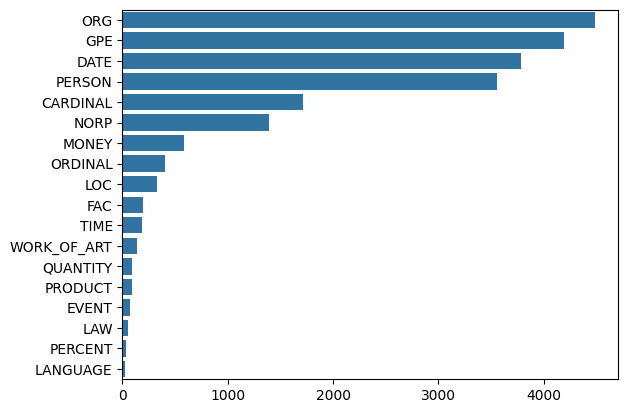

In [84]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)


<Axes: >

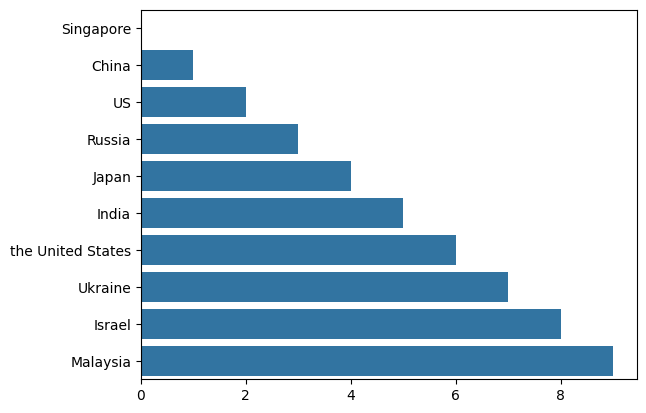

In [86]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=news['Text'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(x)